In [ ]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import seaborn as sns

In [ ]:
import json

def load_data(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data
data=load_data('MentalhealthcareData.json')

In [ ]:
# !pip install spacy
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:

def advanced_preprocess_text(text):
    doc = nlp(text.lower())
    cleaned_text = []
    skip_next = False
    for token in doc:
        if skip_next:
            skip_next = False
            continue
        if token.text == 'not' and token.i + 1 < len(doc):
            cleaned_text.append(token.text + '_' + doc[token.i + 1].lemma_)
            skip_next = True
        elif not token.is_stop and not token.is_punct and token.lemma_ != "-PRON-":
            if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
                cleaned_text.append(token.lemma_)
    return " ".join(cleaned_text)

# Example use:
text_example = "I am not feeling well Today."
processed_text = advanced_preprocess_text(text_example)
print(processed_text)  # Check output to see if it makes sense and isn't single characters


not_feel today


In [ ]:
# Preprocess patterns in intents
for intent in data['intents']:
  intent['processed_pattern']   = advanced_preprocess_text(intent['pattern'])

In [ ]:
for intent in data['intents'][:5]:
    original_text = intent['pattern']
    preprocessed_text =  intent['processed_pattern']
    print(f"Original: {original_text}\nPreprocessed: {preprocessed_text}\n")

Original: How do I navigate cultural differences with my partner's family?
Preprocessed: navigate cultural difference partner family

Original: What should I do if my partner and I have different levels of emotional intelligence?
Preprocessed: partner different level emotional intelligence

Original: How can I support my partner through a career transition?
Preprocessed: support partner career transition

Original: What should I do if my partner and I have different parenting styles?
Preprocessed: partner different parenting style

Original: How do I handle disagreements about money with my partner?
Preprocessed: handle disagreement money partner



In [ ]:
#Convert JSON data into Dataframe
df = pd.json_normalize(data['intents'])




# Exploratory data analytics (eda)

In [ ]:
df.head()

,tag,pattern,response,processed_pattern
0,relationship,How do I navigate cultural differences with my...,Navigating cultural differences with your part...,navigate cultural difference partner family
1,relationship,What should I do if my partner and I have diff...,Differences in emotional intelligence can impa...,partner different level emotional intelligence
2,relationship,How can I support my partner through a career ...,Supporting your partner through a career trans...,support partner career transition
3,relationship,What should I do if my partner and I have diff...,Differences in parenting styles can lead to co...,partner different parenting style
4,relationship,How do I handle disagreements about money with...,Disagreements about money are common in relati...,handle disagreement money partner


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tag                877 non-null    object
 1   pattern            877 non-null    object
 2   response           877 non-null    object
 3   processed_pattern  877 non-null    object
dtypes: object(4)
memory usage: 27.5+ KB


In [ ]:
df.describe()


,tag,pattern,response,processed_pattern
count,877,877,877,877
unique,312,808,826,763
top,anxiety,What is postpartum psychosis?,No problem! Happy to assist.,
freq,49,4,3,26


In [ ]:
# Pattern Analysis
patterns = df['processed_pattern']
print("Number of unique patterns:", len(patterns.unique()))

Number of unique patterns: 763


In [ ]:
# Response Exploration
responses = df['response']
sample_responses = responses.sample(5)
print("Sample Responses:")
for i, response in enumerate(sample_responses):
    print(f"{i+1}. {response}")

Sample Responses:
1. The exact cause of Panic Disorder is not fully understood, but it is believed to involve a combination of genetic, biological, and environmental factors. Individuals with a family history of Panic Disorder or other anxiety disorders may be at higher risk of developing the condition. Neurotransmitter imbalances, particularly involving serotonin and norepinephrine, may play a role in the development of Panic Disorder. Additionally, stressful life events, traumatic experiences, and major life transitions may trigger or exacerbate symptoms in susceptible individuals.
2. Compassion involves recognizing and empathizing with the suffering of oneself and others, along with a desire to alleviate that suffering. Cultivating self-compassion and compassion towards others can enhance mental health by promoting resilience, reducing self-criticism and judgment, fostering emotional well-being, and strengthening social connections.
3. Addiction can contribute to a cycle of mental h

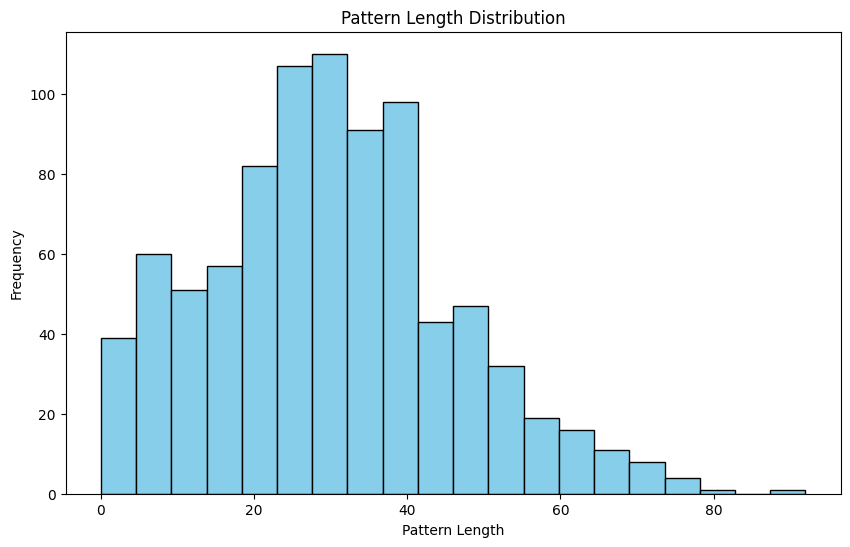

In [ ]:
# Data Visualization
plt.figure(figsize=(10, 6))
plt.hist(patterns.apply(len), bins=20, color='skyblue', edgecolor='black')
plt.title('Pattern Length Distribution')
plt.xlabel('Pattern Length')
plt.ylabel('Frequency')
plt.show()


<ipython-input-15-8c4c4709f8d2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')


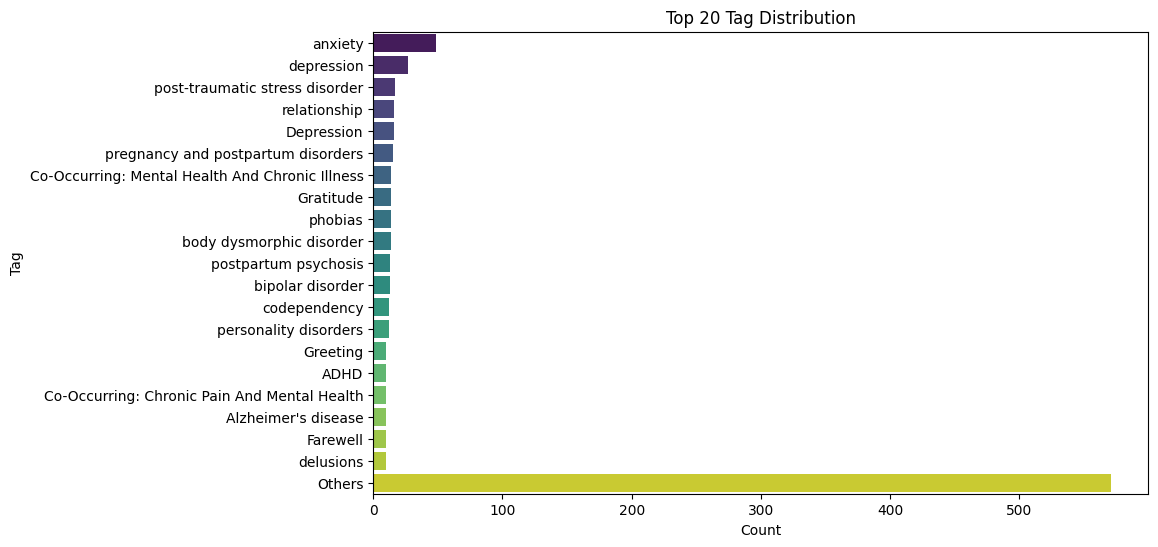

In [ ]:
# Tag Distribution
top_n = 20
tag_counts = df['tag'].value_counts()
top_tags = tag_counts.nlargest(top_n)
other_tags_count = tag_counts.nsmallest(len(tag_counts) - top_n).sum()

# Add 'Others' category
top_tags['Others'] = other_tags_count

plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title(f'Top {top_n} Tag Distribution')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()


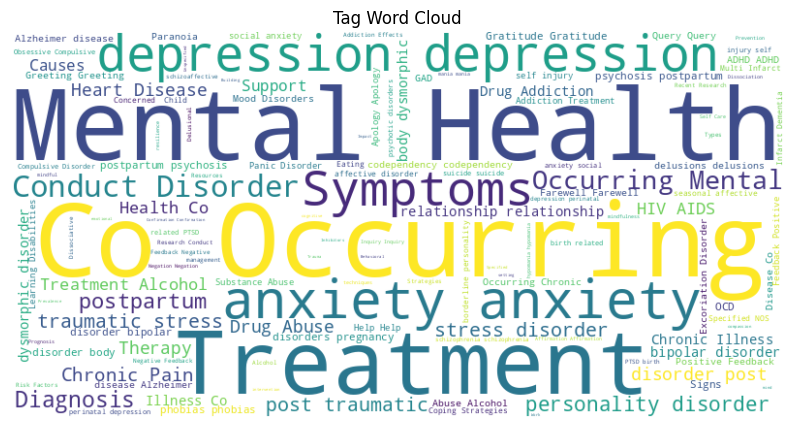

In [ ]:
tags_text = ' '.join(df['tag'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Tag Word Cloud')
plt.axis('off')
plt.show()

# Model Training

In [ ]:
# Define the augment_data function
def augment_data(df, multiplier=5):
    augmented_data = pd.concat([df] * multiplier, ignore_index=True)
    return augmented_data

**Logistic Regression**

In [ ]:

def train_and_evaluate_lr(data_file):


    # Data Augmentation (Example: Duplicate existing samples)
    augmented_df = pd.concat([df] * 5, ignore_index=True)  # Duplicate each sample 5 times

    # Combine original and augmented data
    combined_df = pd.concat([df, augmented_df], ignore_index=True)

    # Split the Combined Data
    X_train, X_test, y_train, y_test = train_test_split(combined_df['pattern'], combined_df['response'], test_size=0.3, random_state=42)
    start_time = time.time()
    # Define a pipeline with TF-IDF Vectorizer and Logistic Regression Classifier (a simpler model)
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression Classifier
    ])


    # Train the pipeline
    pipeline.fit(X_train, y_train)

    end_time = time.time()

    time_lr = end_time - start_time
      # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_lr


In [ ]:

def predict_input_lr(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response

# Example usage:
trained_pipeline_lr, accuracy_lr, time_lr= train_and_evaluate_lr(df)
print("Accuracy:", accuracy_lr)
print("Computation Time:",time_lr)


Accuracy: 0.7118429385687144
Computation Time: 32.06792330741882


**Support Vector Machine**

In [ ]:
def train_and_evaluate_svm(data_file):

    # Load your dataset
    df = data_file

    # Data Augmentation (Example: Duplicate existing samples)
    augmented_df = pd.concat([df] * 5, ignore_index=True)  # Duplicate each sample 5 times

    # Combine original and augmented data
    combined_df = pd.concat([df, augmented_df], ignore_index=True)

    # Split the Combined Data
    X_train, X_test, y_train, y_test = train_test_split(combined_df['pattern'], combined_df['response'], test_size=0.3, random_state=42)

    # Define a pipeline with TF-IDF Vectorizer and SVM Classifier with a non-linear kernel
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
        ('classifier', SVC(kernel='rbf', C=1.0))  # SVM Classifier with a non-linear kernel
    ])
    start_time = time.time()
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    end_time = time.time()

    time_svm = end_time - start_time
    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_svm




In [ ]:
def predict_input_svm(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response


trained_pipeline_svm, accuracy_svm , time_svm = train_and_evaluate_svm(df)
print("Accuracy:", accuracy_svm)
print("Computation Time:",time_svm)





Accuracy: 0.9366687777074097
Computation Time: 2.965792417526245


**Decision Tree**

In [ ]:

# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)


# Define a pipeline with TF-IDF Vectorizer and Decision Tree Classifier
pipeline_DTree = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', DecisionTreeClassifier(random_state=42))  # Decision Tree Classifier
])
start_time = time.time()
# Train the pipeline
pipeline_DTree.fit(X_train, y_train)
end_time = time.time()
time_dt = end_time - start_time
# Predict on test data
y_pred = pipeline_DTree.predict(X_test)



In [ ]:
# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_dt)

print("Computation Time:",time_dt)

# Function to predict response
def predict_input_dt(model,user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response


Accuracy: 0.9399696048632219
Computation Time: 8.528757333755493


**Random forest classifier**

In [ ]:
# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Define a pipeline with TF-IDF Vectorizer and Random Forest Classifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', RandomForestClassifier())  # Random Forest Classifier
])

start_time = time.time()
# Train the pipeline
pipeline_rf.fit(X_train, y_train)
end_time = time.time()
time_rf = end_time - start_time
# Predict on test data
y_pred = pipeline_rf.predict(X_test)



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming y_test and y_pred are the true labels and predicted labels, respectively
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score for each class separately
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

# Calculate macro-averaged precision, recall, and F1-score
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Calculate weighted-averaged precision, recall, and F1-score
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1-score per class:", f1_per_class)
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1-score:", macro_f1)
print("Weighted-averaged Precision:", weighted_precision)
print("Weighted-averaged Recall:", weighted_recall)
print("Weighted-averaged F1-score:", weighted_f1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Accuracy: 0.9399696048632219
Precision per class: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         0.16666667 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.         1.         1.         1.         1.
 0.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.   

In [ ]:


# Calculate accuracy for Random Forest Classifier
accuracy_rf = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", accuracy_rf)
print("Computation Time:",time_rf)

Random Forest Classifier Accuracy: 0.9399696048632219
Computation Time: 15.935280084609985


In [ ]:
def predict_input_rf(model, user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response

**KNN model**

In [ ]:
# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Define a pipeline with TF-IDF Vectorizer and KNN Classifier
pipeline_KNN = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', KNeighborsClassifier())  # KNN Classifier
])
start_time = time.time()
# Train the pipeline
pipeline_KNN.fit(X_train, y_train)
end_time = time.time()
time_knn = end_time - start_time
# Predict on test data
y_pred_knn = pipeline_KNN.predict(X_test)



In [ ]:


# Calculate accuracy for KNN Classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)
print("Computation Time:",time_knn)

KNN Classifier Accuracy: 0.6854103343465046
Computation Time: 0.09924960136413574


In [ ]:
def predict_input_knn(model, user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response

# Accurancy graph

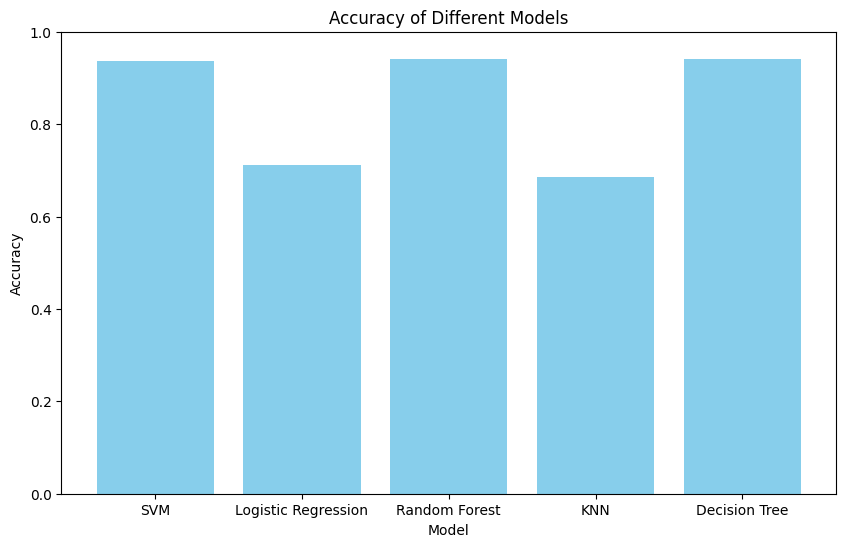

In [ ]:
# List of model names
models = ['SVM', 'Logistic Regression', 'Random Forest', 'KNN', 'Decision Tree']

# List of accuracies for each model
accuracies = [accuracy_svm, accuracy_lr, accuracy_rf, accuracy_knn, accuracy_dt]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.0, 1.0)  # Set the y-axis limit from 0 to 1
plt.show()

# Computation graph

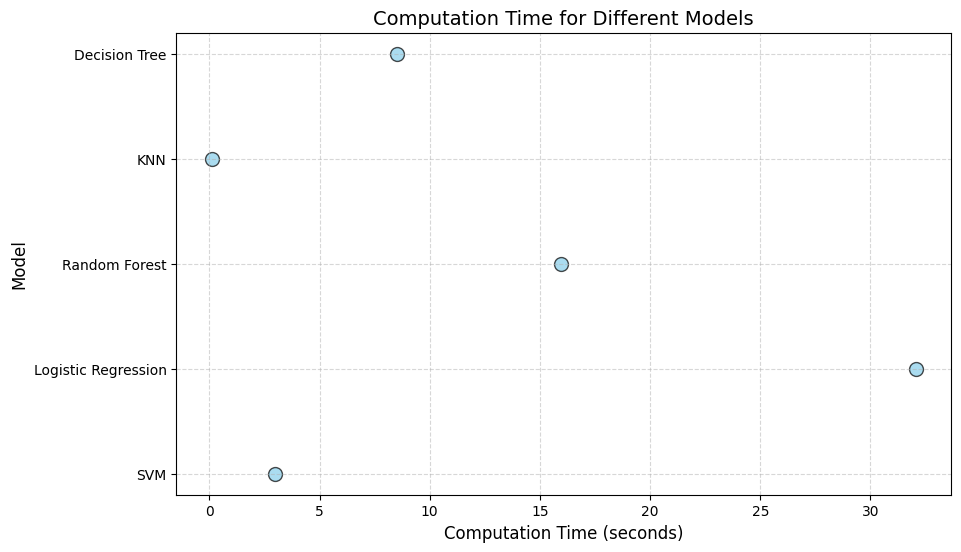

In [ ]:
# List of computation times for each model (replace with actual times)
computation_times = [time_svm, time_lr, time_rf, time_knn, time_dt]
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6))
plt.scatter(computation_times, models, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Computation Time for Different Models', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

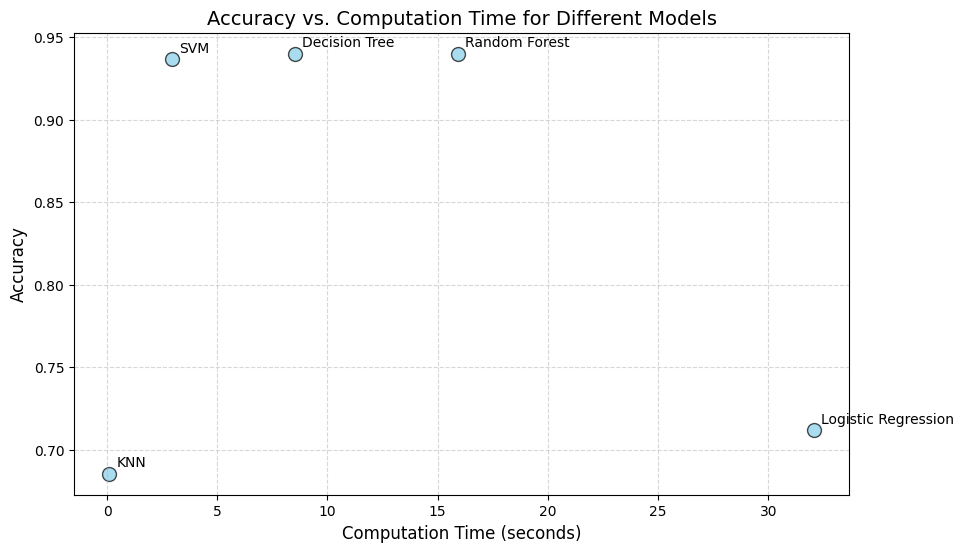

In [ ]:
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6))
plt.scatter(computation_times, accuracies, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs. Computation Time for Different Models', fontsize=14)
for model, time, accuracy in zip(models, computation_times, accuracies):
    plt.annotate(model, (time, accuracy), xytext=(5, 5), textcoords='offset points', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
def chatbot():
    print("Chatbot: Hello! I'm your mental health care assistant. Let's talk about how you're feeling today.")
    user_name = input("Chatbot: Before we begin, may I know your name please? ")

    # Welcome the user by name
    print(f"Chatbot: Nice to meet you, {user_name}! How can I assist you today? Type 'exit' to end our conversation.")

    while True:
        # Take the user's input
        user_input = input(f"{user_name}: ")

        # Preprocess the user input
        # preprocessed_input = advanced_preprocess_text(user_input)
        preprocessed_input = user_input
        # Check if the user wants to exit the conversation
        if user_input.lower() in ['exit', 'quit']:
            print(f"Chatbot: Thank you for talking with me, {user_name}. Take care!")
            break

        # Predict responses using different models
        response_svm = predict_input_svm(trained_pipeline_svm, preprocessed_input)
        response_lr = predict_input_lr(trained_pipeline_lr, preprocessed_input)
        response_rf = predict_input_rf(pipeline_rf, preprocessed_input)
        response_dt = predict_input_dt(pipeline_DTree, preprocessed_input)
        response_knn = predict_input_knn(pipeline_KNN, preprocessed_input)

        # Combine responses from different models
        combined_response = f"SVM: {response_svm}\nLogistic Regression: {response_lr}\nRandom Forest: {response_rf}\nDecision Tree: {response_dt}\nKNN: {response_knn}"

        print("Chatbot:", combined_response)


In [ ]:
# Call the chatbot function to start the conversation
chatbot()

In [ ]:
import joblib

# Save model
joblib.dump(trained_pipeline_svm, 'svm_model.joblib')

# Save model
joblib.dump(pipeline_rf, 'Random_forest_model.joblib')


['Random_forest_model.joblib']

In [ ]:
from google.colab import files
files.download('svm_model.joblib')

In [ ]:
pip freeze


absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.4.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.5
cufflinks==0.17.3
cupy-cuda12x==12.2.0

In [ ]:
pip freeze > 'requirements.txt'